# Customer Churn Prediction: Neural Network Implementation
This implements a custom Neural Network from scratch using NumPy to predict customer churn. It includes a complete preprocessing pipeline featuring log transformations, one-hot encoding, and scaling features.

## 1st Model : 1 hidden layer
- Network Architecture: 
    - 1 hidden layer
    - RelU Activation on Hidden
    - Sigmoid Activation on Output
    - learning rate = 0.01
    - epoch = 500

## Steps:
1. Import Libraries 
2. Read Data from `\Dataset` folder (Retrieved from UCI Repositories)
3. Clean Dataset (rename and format the column)
4. Data Preprocessing
5. Initialize the model
6. Train and test the data
7. Evaluate Performance using graph

### 0. Install Library Requirements

In [29]:
# %pip install jupyter numpy pandas matplotlib seaborn tabulate imblearn

### 1. Import Libraries
Import necessary libraries:
* `numpy`     : High performance array object
* `pandas`    : Data analysis and manipulation tools
* `matplotlib`: Data visualizations
* `seaborn`   : Data visualizations framework based on **matplotlib**
* `tabulate`  : Pretty-print tabular structure library
* `imblearn`  : SMOTE class balance

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns

#### 1.1 Helper Functions
* Handle mathematical operation used in the `NeuralNetwork` Class

In [31]:
def sigmoid(x): return 1 /(1 + np.exp(-x))
def relu(x): return np.maximum(0,x)
def derivative_relu(relu_x): return (relu_x>0).astype(float)
def binary_cross_entropy(y_true, y_pred, epsilon=1e-15):
    # Clip predictions to prevent log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

### 2. Read and Display Dataset Information
load the dataset and understand the data, and use the Interquartile Range (IQR) method to identify potential outliers in numerical columns.
2.1 Read dataset

In [32]:
def read_file(file_path: str):
    df = pd.read_csv(file_path)
    new_columns = [col.strip().replace('  ', ' ').replace(' ', '_').lower() for col in df.columns]
    df.columns = new_columns
    return df

path = r'..\Dataset\Customer Churn.csv'
df = read_file(path)
# df.head(20)
unique = df.nunique()
printunique = pd.DataFrame({'columns': unique.index, 'Values': unique.values})
printunique

,columns,Values
0,call_failure,37
1,complains,2
2,subscription_length,45
3,charge_amount,11
4,seconds_of_use,1756
5,frequency_of_use,242
6,frequency_of_sms,405
7,distinct_called_numbers,92
8,age_group,5
9,tariff_plan,2


2.2 Display dataset data types and null values

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   call_failure             3150 non-null   int64  
 1   complains                3150 non-null   int64  
 2   subscription_length      3150 non-null   int64  
 3   charge_amount            3150 non-null   int64  
 4   seconds_of_use           3150 non-null   int64  
 5   frequency_of_use         3150 non-null   int64  
 6   frequency_of_sms         3150 non-null   int64  
 7   distinct_called_numbers  3150 non-null   int64  
 8   age_group                3150 non-null   int64  
 9   tariff_plan              3150 non-null   int64  
 10  status                   3150 non-null   int64  
 11  age                      3150 non-null   int64  
 12  customer_value           3150 non-null   float64
 13  churn                    3150 non-null   int64  
dtypes: float64(1), int64(13)

2.3 Display dataset shape and its statisical values

In [34]:
df.describe()

,call_failure,complains,subscription_length,charge_amount,seconds_of_use,frequency_of_use,frequency_of_sms,distinct_called_numbers,age_group,tariff_plan,status,age,customer_value,churn
count,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000
mean,7.627937,0.076508,32.541905,0.942857,4472.459683,69.460635,73.174921,23.509841,2.826032,1.077778,1.248254,30.998413,470.972916,0.157143
std,7.263886,0.265851,8.573482,1.521072,4197.908687,57.413308,112.237560,17.217337,0.892555,0.267864,0.432069,8.831095,517.015433,0.363993
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,15.000000,0.000000,0.000000
25%,1.000000,0.000000,30.000000,0.000000,1391.250000,27.000000,6.000000,10.000000,2.000000,1.000000,1.000000,25.000000,113.801250,0.000000
50%,6.000000,0.000000,35.000000,0.000000,2990.000000,54.000000,21.000000,21.000000,3.000000,1.000000,1.000000,30.000000,228.480000,0.000000
75%,12.000000,0.000000,38.000000,1.000000,6478.250000,95.000000,87.000000,34.000000,3.000000,1.000000,1.000000,30.000000,788.388750,0.000000
max,36.000000,1.000000,47.000000,10.000000,17090.000000,255.000000,522.000000,97.000000,5.000000,2.000000,2.000000,55.000000,2165.280000,1.000000


2.4. Detect Outliers

In [35]:
def detect_outliers_iqr(df, k=1.5):
    nums = df.select_dtypes(include='number')
    outlier_info = {}
    
    for c in nums.columns:
        #skip binary columns
        if(nums[c].nunique() <= 2):
            continue
        
        q1 = nums[c].quantile(0.25) #1st quartile
        q3 = nums[c].quantile(0.75) #3rd quartile
        iqr = q3 - q1
        lower = q1 - k * iqr
        upper = q3 + k * iqr
        mask = (nums[c] < lower) | (nums[c] > upper)
        outlier_info[c] = {
            'count': int(mask.sum()),
            'indices': nums.index[mask].tolist(),
            'lower': float(lower),
            'upper': float(upper)
        }
    return outlier_info

outliers = detect_outliers_iqr(df)
table_data = []
print('\nOutlier summary (IQR method):')
for col, info in outliers.items():
    if info['count'] > 0:
    # Calculate percentage
        perc = (info["count"] / len(df)) * 100
        
        # Add a list (row) to our table_data
        table_data.append([col, info["count"], f"{info['lower']:.3f}",
            f"{info['upper']:.3f}", f"{perc:.2f}%"])
headers = ["Column", "Outlier Count", "Lower Bound", "Upper Bound", "Percentage"]
print(tabulate(table_data, headers=headers))
    


Outlier summary (IQR method):
Column                     Outlier Count    Lower Bound    Upper Bound  Percentage
-----------------------  ---------------  -------------  -------------  ------------
call_failure                          47         -15.5           28.5   1.49%
subscription_length                  282          18             50     8.95%
charge_amount                        370          -1.5            2.5   11.75%
seconds_of_use                       200       -6239.25       14108.8   6.35%
frequency_of_use                     129         -75            197     4.10%
frequency_of_sms                     368        -115.5          208.5   11.68%
distinct_called_numbers               77         -26             70     2.44%
age_group                            170           0.5            4.5   5.40%
age                                  688          17.5           37.5   21.84%
customer_value                       116        -898.08        1800.27  3.68%


### 3. Data Cleaning 
This process take step before handling with outliers and data preprocessing.

3.1 Remove Duplicate Row (if any)

In [36]:
df = df.drop_duplicates()
print(f'\n[Changes] Removed duplicate rows. New shape={df.shape}\n')


[Changes] Removed duplicate rows. New shape=(2850, 14)



3.2 Remove Redundant Groups

`age_group` and `age` columns both have the same values but in different types, numeric and nominal respectively.
`age_group` column is dropped to prevent biases when learning

In [37]:
df = df.drop(columns=['age_group'])
print(f'\n[Changes] Dropped column: age_group due to redundancy. New shape={df.shape}\n\n')



[Changes] Dropped column: age_group due to redundancy. New shape=(2850, 13)




### 4. Data Preprocessing

The dataset will follows the exact steps to avoid any imbalance or data leakage during testing.

[Split] -> [Log] -> [Encode] -> [Fit] -> [Scale] -> [Balance]


#### 4.1 Split

* Splitting the dataset into train, and test sets, and both input,X and output,Y
* This function will reset the intialized index of X and Y dataset, and shuffle them before splitting to prevent **data leakage**

@function `split_data()`:
* params
    * `X`, `y` as input and output
    * `test_split` as testing split percentage ; default `0.2`
    * `randomness` as random values for randomize dataset index before splitting ; default `None`
* return
    * `X_train` = Training set without `Churn`
    * `Y_train` = `Churn` Training column
    * `Y_train` = Testing set without `Churn`
    * `Y_test` = `Churn` Testing column


In [38]:
def split_data(X, y, test_split=0.2, randomness=None):
    # Set seed for reproducibility
    if randomness is not None:
        np.random.seed(randomness)
    
    # reset X and Y current index
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    
    # Identify unique classes and their indices (0 and 1)
    unique_classes = np.unique(y)
    train_indices = []
    test_indices = []
    
    for cls in unique_classes:
        # Get indices of rows belonging to this class
        cls_indices = np.where(y == cls)[0]

        # Shuffle indices within this specific class
        np.random.shuffle(cls_indices)

        # Determine the split point
        total_count = len(cls_indices)
        test_count = int(total_count * test_split)
        
        # Split indices
        cls_test = cls_indices[:test_count]
        cls_train = cls_indices[test_count:]
        
        # Add to main lists
        test_indices.extend(cls_test)
        train_indices.extend(cls_train)
        
    # Shuffle the final combined indices so they aren't grouped by class
    np.random.shuffle(train_indices)
    np.random.shuffle(test_indices)
    
    # Use .iloc for DataFrames to select the rows
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    return X_train, X_test, y_train, y_test

X = df.drop(columns=['churn'], axis=1)
Y = df['churn']
X_train,X_test,y_train,y_test = split_data(X,Y,test_split=0.2, randomness=42)
print(f'[Changes] Successfully split data into Training and Testing.')


[Changes] Successfully split data into Training and Testing.


#### 4.2 Log Transformation

* This will treat the outliers found before, compressing all the values within the dataset to **reduce** the skewness of the data
* This step is to prevent unfair patterns.
* Use `numpy.log(1 + x)`
* log transformation on seperated train and test set to prevent **data leakage**

@function `log_transformation()`:
* params
    * `df_train`, `df_test` as training and testing dataset
    * `cols_log` as list of column to be log transformed
* return
    * `df_train` = train dataset that have been log transformed
    * `df_test` = test dataset that have been log transformed

In [39]:
def log_transformation(df_train, df_test, cols_log: list):
    for col in cols_log:
        df_train[col] = np.log1p(df_train[col])
        df_test[col] = np.log1p(df_test[col])
    print(f'[Changes] Applied log transformation to selected columns.')
    return df_train, df_test

cols_to_log = [
    'seconds_of_use',
    'frequency_of_use',
    'frequency_of_sms',
    'distinct_called_numbers',
    'call_failure',
    'customer_value',
    'charge_amount'
]
X_train, X_test = log_transformation(X_train,X_test,cols_to_log)
    

[Changes] Applied log transformation to selected columns.


#### 4.3 One-Hot Encoding

* Convert categorical column into multiple, numeric dummy columns that values between `0` and `1`.
* Example: `plan` have 3 categories  = `[cat1, cat2, cat3]`. It will split into dummy columns for each category, `plan_cat1`, `plan_cat2`, `plan_cat3` 
* use drop first column attribute to prevent **multicollinearity**

@function `get_train_category()`:
* params
    * `df` as dataset
    * `col_name` retrieve category from this column
* return
    * `list` = list of column name


@function `one_hot_encoding()`:
* params
    * `df` as dataset
    * `col_name` as column name that will apply one-hot encoding
    * `categories` as category inside `col_name`
    * `drop_first` drop first column to simplify the dummy column
* return
    * `converted_pd` = return the dataframe with the added dummy columns 

In [40]:
def get_train_categories(df, col_name):
    return sorted(list(set(df[col_name].tolist())))

def one_hot_encoding(df, col_name:str, categories, drop_first = True):
    data = df[col_name].tolist()
    
    active_cats = categories[1:] if drop_first and len(categories) > 1 else categories
    
    encoded_mtx = []
    for item in data:
        row = [0] * len(active_cats)
        if item in active_cats:
            index = active_cats.index(item)
            row[index] = 1
        encoded_mtx.append(row)
    
    #rename column for one hot encoded column
    new_cols = [f'{col_name}_{cat}' for cat in active_cats]
    #convert back to dataframe
    converted_pd  = pd.DataFrame(encoded_mtx, columns=new_cols,index=df.index)
    return converted_pd

train_encoded_parts = []
test_encoded_parts = []

categorical = ['complains', 'tariff_plan', 'status']
for col in categorical:
    train_categories = get_train_categories(X_train, col)
    train_encoded_parts.append(one_hot_encoding(X_train, col, train_categories, drop_first=True))        
    test_encoded_parts.append(one_hot_encoding(X_test, col, train_categories, drop_first=True))
print(f'[Changes] Applied one hot encoding to categorical columns')

#drop old column and join new columns
X_train = X_train.drop(columns=categorical).join(train_encoded_parts)
X_test = X_test.drop(columns=categorical).join(test_encoded_parts)

[Changes] Applied one hot encoding to categorical columns


#### 4.4 Scaling Feature

* Transforms features to fit within a specific range, usually `0`, by subtracting the minimum value and dividing by the range `(max - min)`
* Using `min()` and `max()` function to retrieve the minimum and maximum value in a column
* Scales the transformation on training data, and transform on train and test dataset to prevent data leakage

@function `get_scaling_params()`:
* params
    * `df_train` as training input dataset
* return
    * `param_dict` = a dictionary contains the minimum and maximum value for every key column

@function `min_max_transform()`:
* params
    * `df` as input dataset
    * `params` as dicitionary containing min and max value for each column
* return
    * `df_scaled` = scaled dataset 

In [41]:
def get_scaling_params(df_train):
    param_dict = {}
    for col in df_train.columns:   
        min_val = min(df_train[col])
        max_val = max(df_train[col])
        param_dict[col] = (min_val, max_val - min_val)
    return param_dict

#eg: min_max_transform(X_TEST, train_min_val, train_data_range)
def min_max_transform(df, params: dict):
    df_scaled = df.copy()

    for col, (min_v, data_range) in params.items():
        if data_range == 0:
            df_scaled[col] = 0.0 #base case float number
        else:
            df_scaled[col] = (df[col] - min_v) / data_range
            
    return df_scaled

X_train_scale_params = get_scaling_params(X_train)
X_train_scaled = min_max_transform(X_train, X_train_scale_params)
X_test_scaled = min_max_transform(X_test, X_train_scale_params)
print(f'[Changes] Applied Min Max Scaler on numerical columns')

[Changes] Applied Min Max Scaler on numerical columns


#### 4.5 Class Balancing

* The dataset contains around 80% `0` (Not Churn) and 20% `1` (Churn), causing imbalance and can cause the model to become biased, favor the majority class, and perform poorly on the crucial minority class.
* `SMOTE` is a **oversampling** technique used to create synthetic data using its algorithm to balance the class.
* Only apply to training data only to prevent data leakage

In [42]:
# smote = SMOTE(sampling_strategy=0.8, random_state=42)
# X_train_final, y_train_final = smote.fit_resample(X_train_scaled, y_train)
# print(f"Before SMOTE - Class Distribution: {y_train.value_counts()}")
# print(f"After SMOTE - Class Distribution: {pd.Series(y_train_final).value_counts()}")
# print(f"Final training set size: {len(X_train_final)}")

### 5. Initialize the Model

#### 5.1 Intialize Variables
* `EPOCHS`      : Iteration counts
* `PATIENCE`    : Hyperparameter stopping condition that wait for an improvement
* `input_dim` = input layer size (nodes)

In [43]:
# Step 1: Initialization
EPOCHS = 500
PATIENCE = 100

input_dim = X_train_scaled.shape[1]

@Class `NeuralNetwork`
* A multi-layer perceptron (Backpropagation Neural Network) designed for binary classification.
* He initialization for weight stability, gradient descent, and early stopping based on patience or error thresholds.

@function `feedforward()`:
* Feed the data forward, [Input] -> w1 -> [Hidden] -> w2 -> [Output]
* Input to hidden layer will use **ReLU** activation function to handle nonlinear
* Hidden layer to output layer will use **Sigmoid** activation function to **0 - 1** output

@function `backpropagation()`:
* Calculates the gradients of the loss function with respect to each weight and bias in the network.
* Uses Gradient Clipping (max value of 5.0) to prevent exploding gradients and stability.
* Updates weight1, weight2, bias1, and bias2 using the calculated deltas and the learning rate (`alpha`).

@function `train()`
* Manages the entire learning process over a set number of EPOCHS using  Gradient Descent.
* Shuffles the training data every epoch to improve generalization and prevent the model from learning the order of the data.
* Stopping Condition:
    * `max_error`
    * `patience`

@function `calculate_accuracy()`
* Computes the percentage of correct predictions by comparing predicted probabilities against true labels
* 0.5 threshold to convert sigmoid probabilities into binary classes (0 or 1).

@function `predict()`
* Performs a final feedforward pass on unseen data to generate class predictions.
* Flattens the final output and applies a boolean threshold (0.5) to return integer class labels.

In [44]:
class NeuralNetwork:
    def __init__(self, input_dimension, hidden_nodes = 8, alpha = 0.01):
        #Step 0: Initialization
        self.alpha = alpha
        self.weight1 = np.random.randn(input_dimension, hidden_nodes) * np.sqrt(2/input_dimension) #He Initializaion keeps Weight stable
        self.weight2 = np.random.randn(hidden_nodes, 1) * np.sqrt(2/hidden_nodes)
        self.bias1 = np.zeros((1, hidden_nodes))
        self.bias2 = np.zeros((1, 1))
        
        self.train_loss, self.test_loss, self.train_acc, self.test_acc = [], [], [], []
        self.history = {
            'train_loss': self.train_loss,
            'test_loss': self.test_loss,
            'train_acc': self.train_acc,
            'test_acc': self.test_acc
        }    
        
    
    def feedforward(self,X):
        # Step 1 : Calc Hidden Layer
        self.hidden_Z = X @ self.weight1 + self.bias1
        self.hidden_A = relu(self.hidden_Z)
        
        # Step 2: Calc Output Layer
        self.output_Z = self.hidden_A @ self.weight2 + self.bias2
        self.output_A= sigmoid(self.output_Z)
        
        return self.output_A
    
    def backpropagation(self, X, y, output):
        size = y.shape[0] 
        
        # Step 3: Calculate Error
        d_output = (output - y)
        
        # Step 4: Calculate Output Error Gradient
        d_weight2 = self.hidden_A.T @ d_output / size
        d_bias2 = np.sum(d_output, axis=0, keepdims=True) / size
        
        # Step 5: Calculate Hidden Error Gradient
        d_hidden = d_output @ self.weight2.T
        d_hidden_Z = d_hidden * derivative_relu(self.hidden_Z)
        d_weight1 = X.T @ d_hidden_Z / size
        d_bias1 = np.sum(d_hidden_Z, axis=0, keepdims=True) / size
        
        # Step 6: Update Output Weight
        self.weight2 -= self.alpha * d_weight2
        self.bias2 -= self.alpha * d_bias2
        
        # Step 7 and 8: Update Hidden Weight
        self.weight1 -= self.alpha * d_weight1
        self.bias1 -= self.alpha * d_bias1

    def calculate_accuracy(self, y_true, y_pred_prob):
        # Threshold at 0.5 for binary classification
        predictions = (y_pred_prob > 0.5).astype(int)
        correct = np.sum(predictions == y_true)
        return correct / len(y_true)
    
    def train(self, X_train, y_train, X_test, y_test):
        epochs = EPOCHS
        max_error = 0.01
        best_loss = float('inf')
        patience_count = 0
        patience = PATIENCE
        
        X_tr = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
        y_tr = np.array(y_train).reshape(-1, 1)
        X_te = X_test.values if isinstance(X_test, pd.DataFrame) else X_test
        y_te = np.array(y_test).reshape(-1, 1)
        
        n_samples = X_tr.shape[0]
        
        for epoch in range(epochs):
            
            # Shuffle data each epoch
            indices = np.random.permutation(n_samples)
            
            # Calculate metrics on full dataset
            output_full = self.feedforward(X_tr)
            
            self.backpropagation(X_tr, y_tr, output_full)
            
            train_loss = binary_cross_entropy(y_tr, output_full)
            train_acc = np.mean((output_full > 0.5).astype(int) == y_tr) * 100
            
            output_test = self.feedforward(X_te)
            test_loss = binary_cross_entropy(y_te, output_test)
            test_acc = np.mean((output_test > 0.5).astype(int) == y_te) * 100
            
            self.train_loss.append(train_loss)
            self.test_loss.append(test_loss)
            self.train_acc.append(train_acc)
            self.test_acc.append(test_acc)
            
            print(f'Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')
            
            if test_loss < best_loss:
                best_loss = test_loss
                patience_count = 0
            else:
                patience_count += 1
            
            if patience_count >= patience:
                print(f'[Training Stopped] Patience {patience} reached')
                break
            
            if train_loss <= max_error:
                print(f'[Training Stopped] Max error {max_error} reached')
                break
            
        return self.history

    def predict(self, X):
        X_vals = X.values if isinstance(X, pd.DataFrame) else X
        #forward pass
        h_input = np.dot(X_vals, self.weight1) + self.bias1
        h_output = relu(h_input)
        o_input = np.dot(h_output, self.weight2) + self.bias2
        probs = sigmoid(o_input)
        # Return 0 or 1
        return (probs > 0.5).astype(int).flatten()

5.2 Initialize, Train and Predict

* Input Layer : 12 nodes
* Hidden Layer : 8 nodes
* Learning Rate : 0.01
* Epochs : 500

In [45]:

nn = NeuralNetwork(input_dimension= input_dim, alpha=0.01)
history = nn.train(X_train_scaled, y_train, X_test_scaled, y_test)    
y_hat = nn.predict(X_test_scaled)

print('Model finished training and validation.')


Epoch 1/500 | Train Loss: 0.6047 | Train Acc: 83.69% | Test Loss: 0.5994 | Test Acc: 84.18%
Epoch 2/500 | Train Loss: 0.6013 | Train Acc: 83.78% | Test Loss: 0.5961 | Test Acc: 84.36%
Epoch 3/500 | Train Loss: 0.5979 | Train Acc: 83.91% | Test Loss: 0.5929 | Test Acc: 84.36%
Epoch 4/500 | Train Loss: 0.5947 | Train Acc: 83.91% | Test Loss: 0.5898 | Test Acc: 84.36%
Epoch 5/500 | Train Loss: 0.5915 | Train Acc: 84.22% | Test Loss: 0.5867 | Test Acc: 84.36%
Epoch 6/500 | Train Loss: 0.5883 | Train Acc: 84.35% | Test Loss: 0.5837 | Test Acc: 84.36%
Epoch 7/500 | Train Loss: 0.5852 | Train Acc: 84.35% | Test Loss: 0.5808 | Test Acc: 84.36%
Epoch 8/500 | Train Loss: 0.5822 | Train Acc: 84.35% | Test Loss: 0.5779 | Test Acc: 84.36%
Epoch 9/500 | Train Loss: 0.5793 | Train Acc: 84.35% | Test Loss: 0.5750 | Test Acc: 84.36%
Epoch 10/500 | Train Loss: 0.5764 | Train Acc: 84.35% | Test Loss: 0.5723 | Test Acc: 84.36%
Epoch 11/500 | Train Loss: 0.5735 | Train Acc: 84.35% | Test Loss: 0.5695 | Tes

@function `evaluate_model_performance()`:

* Generates a comprehensive visual report of the model's training history and final classification performance in a 3-row vertical layout.

* **Loss Curve**: Visualizes the relationship between training and validation loss across epochs to detect overfitting or convergence issues.

* **Accuracy Curve** : Tracks the percentage of correct predictions over time for both the training and test sets.

* **Confusion Matrix** : Calculate the classification metrics (TP, TN, FP, FN) and displays them as a Seaborn heatmap for error analysis.

* params
    * `history`: A dictionary containing the logged lists of loss and accuracy values.
    * `y_true` : The truth labels from the test dataset.
    * `y_pred` : The binary predictions (0 or 1) generated by the model.
    * `title` : string used as the main heading for the entire figure.

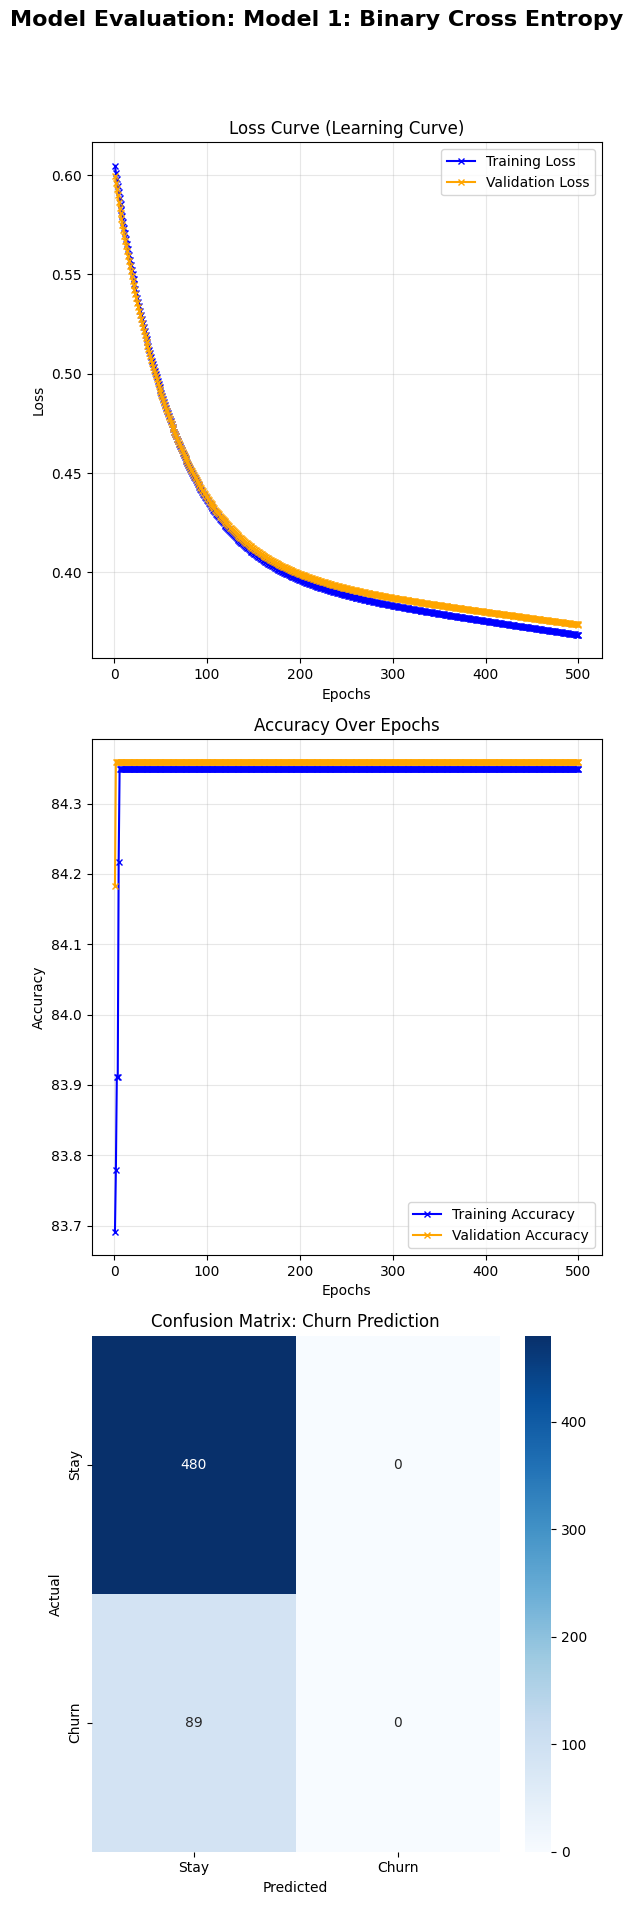

In [46]:
def evaluate_model_performance(history:dict, y_true:list, y_pred:list, title:str):
    # Create a figure within 3 rows
    fig, axes = plt.subplots(3, 1, figsize=(6, 20))
    fig.suptitle(f'Model Evaluation: {title}', fontsize=16, fontweight='bold')

    # --- 1. Loss Curve Plot ---
    train_loss = history['train_loss']
    val_loss = history['test_loss']
    epochs = range(1, len(train_loss) + 1)

    axes[0].plot(epochs, train_loss, label='Training Loss', color='blue', lw=1.5, marker='x', ms=4)
    axes[0].plot(epochs, val_loss, label='Validation Loss', color='orange', lw=1.5, marker='x', ms=4)
    axes[0].set_title('Loss Curve (Learning Curve)')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # --- 2. Accuracy Plot ---
    train_acc = history['train_acc']
    val_acc = history['test_acc']
    axes[1].plot(epochs, train_acc, label='Training Accuracy', color='blue', lw=1.5, marker='x', ms=4)
    axes[1].plot(epochs, val_acc, label='Validation Accuracy', color='orange', lw=1.5, marker='x', ms=4)
    axes[1].set_title('Accuracy Over Epochs')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # --- 3. Confusion Matrix ---
    actual = np.array(y_true).flatten()
    predicted = np.array(y_pred).flatten()
    
    tp = np.sum((actual == 1) & (predicted == 1))
    tn = np.sum((actual == 0) & (predicted == 0))
    fp = np.sum((actual == 0) & (predicted == 1))
    fn = np.sum((actual == 1) & (predicted == 0))
    cm = np.array([[tn, fp], [fn, tp]])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Stay', 'Churn'], 
            yticklabels=['Stay', 'Churn'],
            ax=axes[2])
    axes[2].set_title('Confusion Matrix: Churn Prediction')
    axes[2].set_ylabel('Actual')
    axes[2].set_xlabel('Predicted')
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
evaluate_model_performance(history, y_test, y_hat, title='Model 1: Binary Cross Entropy')